# Flow Matching

## Data

In [1]:
from tqdm.notebook import tqdm
import math
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from data_2d import generate_swastika, generate_spiral, generate_psi

In [2]:
def get_dataset(dataset_name:str='psi',  num_points_per_segment:int=1000, noise_std:float=0.02):
    if dataset_name == 'psi':
        sampled_points = generate_psi(num_points_per_segment=N, noise_std=nstd)
    
    if dataset_name == 'spiral':
        sampled_points = generate_spiral(num_points_per_segment=N, noise_std=nstd)
        
    if dataset_name == 'swastika':
        sampled_points = generate_swastika(num_points_per_segment=N, noise_std=nstd)
        
    else:
        sampled_points = generate_psi(num_points_per_segment=N, noise_std=nstd)
    return sampled_points

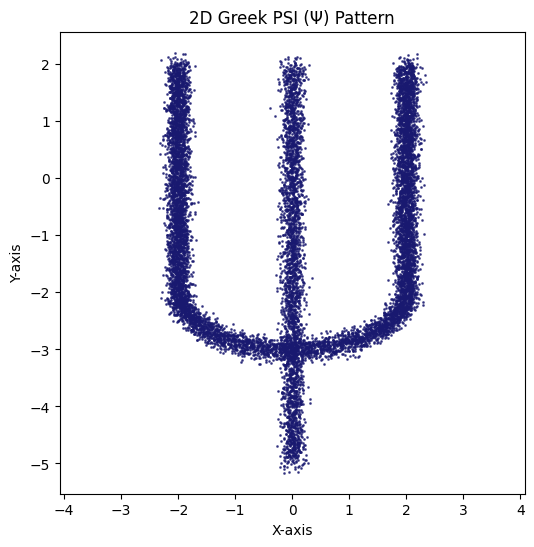

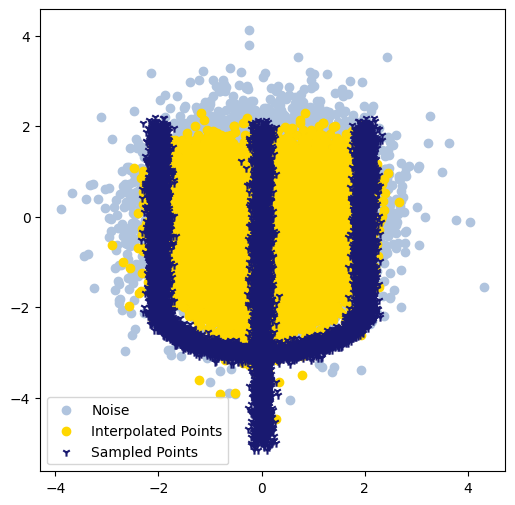

In [3]:
# Parameters
N = 3000  # Number of points per segment
nstd = 0.1 # Noise standard deviation

# Generate Ψ data points
sampled_points = get_dataset(dataset_name='phi', num_points_per_segment=N, noise_std=nstd)

# Visualize the Ψ pattern
plt.figure(figsize=(6, 6))
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], s=1, alpha=0.7, c='midnightblue')
plt.title("2D Greek PSI (Ψ) Pattern")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.axis("equal")
plt.show()

# Linear interpolation between sampled_points and noise
t = 0.5
# Generate noise with the same shape as sampled_points
noise = np.random.randn(4 * N, 2)  # Changed to match sampled_points shape
plt.figure(figsize=(6, 6))
plt.scatter(noise[:, 0], noise[:, 1], color="lightsteelblue", marker="o", label="Noise")
interpolated_points = (1 - t) * noise + t * sampled_points.numpy()
plt.scatter(interpolated_points[:, 0], interpolated_points[:, 1], color="gold", marker="o", label="Interpolated Points")
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="midnightblue", marker="1", label="Sampled Points")

plt.legend()
plt.show()

## Model

In [4]:
class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, channels_data=2, layers=5, channels=512, channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)
        self.blocks = nn.Sequential(*[
            Block(channels) for _ in range(layers)
        ])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb = math.log(max_positions) / (half_dim - 1)
        emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp()
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.channels_t % 2 == 1:  # zero pad
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t):
        x = self.in_projection(x)
        t = self.gen_t_embedding(t)
        t = self.t_projection(t)
        x = x + t 
        x = self.blocks(x)
        x = self.out_projection(x)
        return x

In [5]:
model = MLP(layers=5, channels=512)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

## Training

In [ ]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming `sampled_points`, `model`, and `optim` are defined earlier in your code
data = torch.Tensor(sampled_points).to(device)  # Move data to the device
model = model.to(device)  # Move model to the device

training_steps = 100_000
batch_size = 512
pbar = tqdm(range(training_steps),  position=0, leave=True)
losses = []

for i in pbar:
    # Sample a batch of data
    x1 = data[torch.randint(data.size(0), (batch_size,))].to(device)
    x0 = torch.randn_like(x1).to(device)  # Random tensor with the same shape as x1
    target = x1 - x0
    t = torch.rand(x1.size(0), device=device)  # Generate t on the correct device
    xt = (1 - t[:, None]) * x0 + t[:, None] * x1
    pred = model(xt, t)  # Pass xt and t to the model
    loss = ((target - pred)**2).mean()
    
    # Backpropagation
    loss.backward()
    optim.step()
    optim.zero_grad()
    
    # Update progress bar and store loss
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 91208/100000 [34:20<04:15, 34.45it/s, loss=2.25]

In [ ]:
plt.plot(losses)

## Sampling

In [ ]:
torch.manual_seed(42)
model.eval().requires_grad_(False)
xt = torch.randn(1000, 2)
steps = N
plot_every = 100*3
for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
    pred = model(xt.to(device), t.expand(xt.size(0)).to(device))
    xt = xt.to(device) + (1 / steps) * pred.to(device)
    if i % plot_every == 0:
        plt.figure(figsize=(6, 6))
        plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="midnightblue", marker="o")
        plt.scatter(xt[:, 0].cpu(), xt[:, 1].cpu(), color="lightsteelblue", marker="o")
        plt.axis('off')
        plt.show()
model.train().requires_grad_(True)
print("Done Sampling")

In [ ]:
import imageio
from pathlib import Path

# Ensure reproducibility
torch.manual_seed(42)

# Assuming the model is already defined and loaded
model.eval().requires_grad_(False)

# Generate random initial points
xt = torch.randn(1000, 2)
steps = N  # Number of timesteps (from previous code)
plot_every = 100 * 3  # Frequency of plotting

# Directory to save the frames
frames_dir = Path("frames")
frames_dir.mkdir(exist_ok=True)

# Generate GIF frames
frames = []
for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
    pred = model(xt.to(device), t.expand(xt.size(0)).to(device))
    xt = xt.to(device) + (1 / steps) * pred.to(device)

    if i % plot_every == 0:
        plt.figure(figsize=(6, 6))
        plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="midnightblue", marker="o", label="Sampled Points")
        plt.scatter(xt[:, 0].cpu(), xt[:, 1].cpu(), color="lightsteelblue", marker="o", label="Flow matching Points")
        plt.axis('off')

        # Place the legend outside the plot
        plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)
        
        # Save the current frame
        frame_path = frames_dir / f"frame_{i:04d}.png"
        plt.savefig(frame_path)
        frames.append(frame_path)
        plt.close()

# Create the GIF with looping enabled
gif_path = "sampling_process.gif"
with imageio.get_writer(gif_path, mode="I", duration=0.1, loop=0) as writer:
    for frame in frames:
        writer.append_data(imageio.imread(frame))
        
# Clean up frames directory (optional)
for frame in frames:
    frame.unlink()
frames_dir.rmdir()

print(f"Done Sampling! GIF saved as {gif_path}")


In [ ]:
from IPython.display import Image, display, Markdown

# Read the video file
try:
    display(Image(data=open(gif_path,'rb').read(), format='png'))
except Exception as e:
    print(str(e))
    pass